# Reading Data

In [4]:
# Imports
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn. metrics import roc_auc_score, confusion_matrix

In [5]:
import os
flights_df = pd.read_csv("flights_clean_merged.csv", index_col=False)
flights_df.head(10)

,Unnamed: 0,DESTINATION_AIRPORT,ORIGIN_AIRPORT,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY
0,1,9,7,3,27,5,EV,5438,N846AS,10:00:00,85,425,16
1,2,9,7,3,17,2,EV,5199,N883AS,20:30:00,84,425,1
2,3,9,2,5,2,6,DL,2582,N894AT,20:30:00,123,692,-15
3,4,9,2,9,11,5,EV,5870,N11548,08:30:00,115,654,6
4,5,9,2,12,9,3,EV,6168,N17138,21:00:00,111,655,1
5,6,9,2,3,12,4,EV,6050,N12900,13:30:00,112,654,-2
6,7,9,7,3,26,4,OO,4507,N8965E,14:00:00,86,425,3
7,8,9,2,5,8,5,DL,2582,N922AT,20:30:00,126,692,-16
8,9,9,7,5,12,2,EV,5218,N848AS,10:00:00,85,425,-6
9,10,9,2,10,8,4,EV,5197,N872AS,14:30:00,122,692,-4


In [6]:
flights_df.columns.values

array(['Unnamed: 0', 'DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'MONTH',
       'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
       'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE',
       'ARRIVAL_DELAY'], dtype=object)

In [7]:
flights_df.drop(columns=['Unnamed: 0'])

,DESTINATION_AIRPORT,ORIGIN_AIRPORT,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY
0,9,7,3,27,5,EV,5438,N846AS,10:00:00,85,425,16
1,9,7,3,17,2,EV,5199,N883AS,20:30:00,84,425,1
2,9,2,5,2,6,DL,2582,N894AT,20:30:00,123,692,-15
3,9,2,9,11,5,EV,5870,N11548,08:30:00,115,654,6
4,9,2,12,9,3,EV,6168,N17138,21:00:00,111,655,1
5,9,2,3,12,4,EV,6050,N12900,13:30:00,112,654,-2
6,9,7,3,26,4,OO,4507,N8965E,14:00:00,86,425,3
7,9,2,5,8,5,DL,2582,N922AT,20:30:00,126,692,-16
8,9,7,5,12,2,EV,5218,N848AS,10:00:00,85,425,-6
9,9,2,10,8,4,EV,5197,N872AS,14:30:00,122,692,-4


# Preprocessing

In [8]:
#converting response variable to 
delay_cutoff = 15
flights_df["ARRIVAL_DELAY"] = flights_df["ARRIVAL_DELAY"].apply(lambda x: 0 if x<15 else 1)
flights_df = flights_df.reset_index(drop=True)
labels_shuffle = flights_df["ARRIVAL_DELAY"]
labels_shuffle.shape

(5713508,)

In [9]:
#Function for one hot-encoding
def make_onehot_feat_dict(df, feat_key, feat_name):
    # Create features for each day of the week
    feat_vals = df[feat_key].values
    all_vals = np.unique(feat_vals)
    N_vals = len(all_vals)
    N_feat = N_vals - 1

    # Create keys
    keys = [0]*N_feat
    for i in range(N_feat):
        keys[i] = 'f_'+feat_name+'_'+ str(all_vals[i])

    # Create value for each training example in dict
    feat_dict = {}
    for i, k in enumerate(keys):
        this_day = all_vals[i]
        feat_dict[k] = feat_vals == this_day
    return feat_dict

In [10]:
#converting day of week into one-hot
daysfeat_dict = make_onehot_feat_dict(flights_df, 'DAY_OF_WEEK', 'day')

In [11]:
#converting months into one-hot
monthsfeat_dict = make_onehot_feat_dict(flights_df, 'MONTH', 'month')

In [12]:
#converting origin airport into one-hot
apfeat_dict = make_onehot_feat_dict(flights_df, 'ORIGIN_AIRPORT', 'aa')

In [13]:
#converting destination airport into one-hot
deafeat_dict = make_onehot_feat_dict(flights_df, 'DESTINATION_AIRPORT', 'da')

In [14]:
#converting Airlines into one-hot
alfeat_dict = make_onehot_feat_dict(flights_df, 'AIRLINE', 'al')

In [15]:
# Add departure hour as a feature
flights_df['HOUR_DEPARTURE'] = flights_df['SCHEDULED_DEPARTURE'].astype(str).str[:2]
#converting hours departure into one-hot
hrfeat_dict = make_onehot_feat_dict(flights_df, 'HOUR_DEPARTURE', 'hr')

In [16]:
all_dicts = [deafeat_dict, daysfeat_dict, monthsfeat_dict, alfeat_dict, hrfeat_dict, apfeat_dict]
feat_dict = all_dicts[0].copy()
for d in all_dicts[1:]:
    feat_dict.update(d)

In [17]:
df_feat = pd.DataFrame.from_dict(feat_dict)
df_feat = pd.concat([df_feat, flights_df["SCHEDULED_TIME"], flights_df["DISTANCE"]], axis=1)
df_feat.shape

(5713508, 70)

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_feat, flights_df["ARRIVAL_DELAY"], test_size=0.20, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4570806, 70)
(1142702, 70)
(4570806,)
(1142702,)


# Random Forest 

In [24]:
rf = RandomForestClassifier(n_estimators = 25, random_state = 69)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=69, verbose=0, warm_start=False)

In [25]:
preds_train = rf.predict(x_train)

In [26]:
preds_val = rf.predict(x_test)


In [28]:
print(rf.score(x_train, y_train))
print(sum(rf.predict(x_train)))
print(rf.score(x_test, y_test))
print(sum(rf.predict(x_test)))

0.8722993275146659
564458
0.76103218511913
145697


0.6075594895258158


(0, 1)

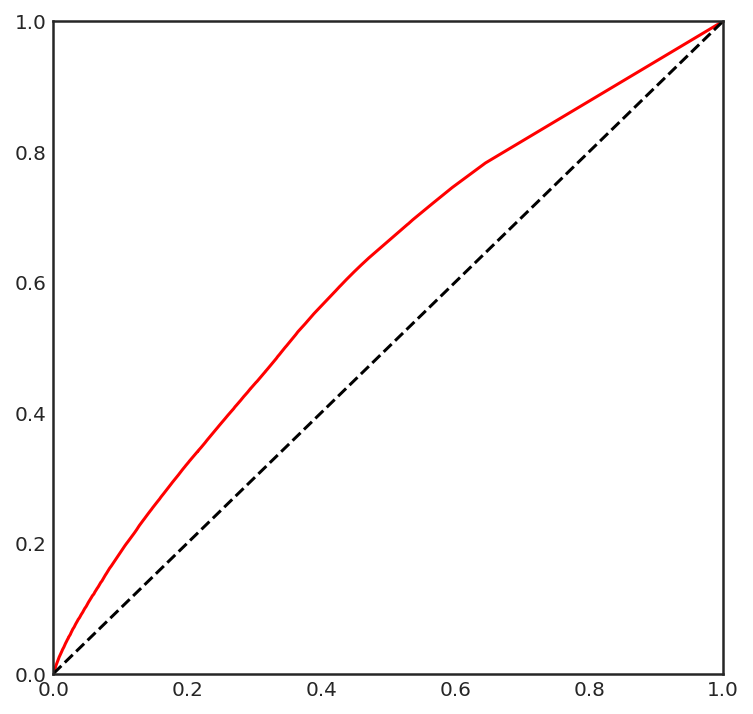

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, th = roc_curve(y_test, rf.predict_proba(x_test)[:,1])
print(roc_auc_score(y_test, rf.predict_proba(x_test)[:,1]))

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

Confusion matrix:
 [[826787 102723]
 [170301  42891]]
Precision:  0.29455272157896906
Recall:  0.20118484746144322
Accuracy:  0.7610715654650119
False Negative Rate:  0.17079836483840946
Accuracy:  0.7610715654650119
0.5453358907187045


(0, 1)

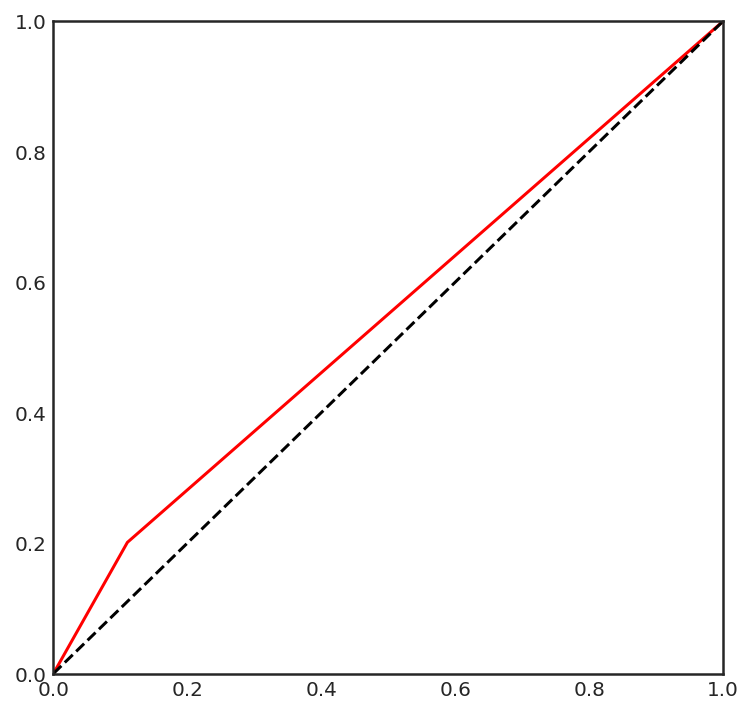

In [31]:
from sklearn.metrics import confusion_matrix
decision_thresh = .5
all_preds = rf.predict_proba(x_test)[:,1] > decision_thresh
all_ys = y_test
all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
print('False Negative Rate: ', all_confuse[1,0]/(all_confuse[1,0]+all_confuse[0,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

# Gradient Boosting

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix

In [20]:
gb = GradientBoostingClassifier(n_estimators=25, learning_rate=1.0, max_depth=1)
gb.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=25,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [21]:
preds_train = gb.predict(x_train)
preds_val = gb.predict(x_test)

In [22]:
print(gb.score(x_train, y_train))
print(sum(gb.predict(x_train)))
print(gb.score(x_test, y_test))
print(sum(gb.predict(x_test)))

0.8139831355782766
0
0.8134316733496573
0


0.6371160940197224


(0, 1)

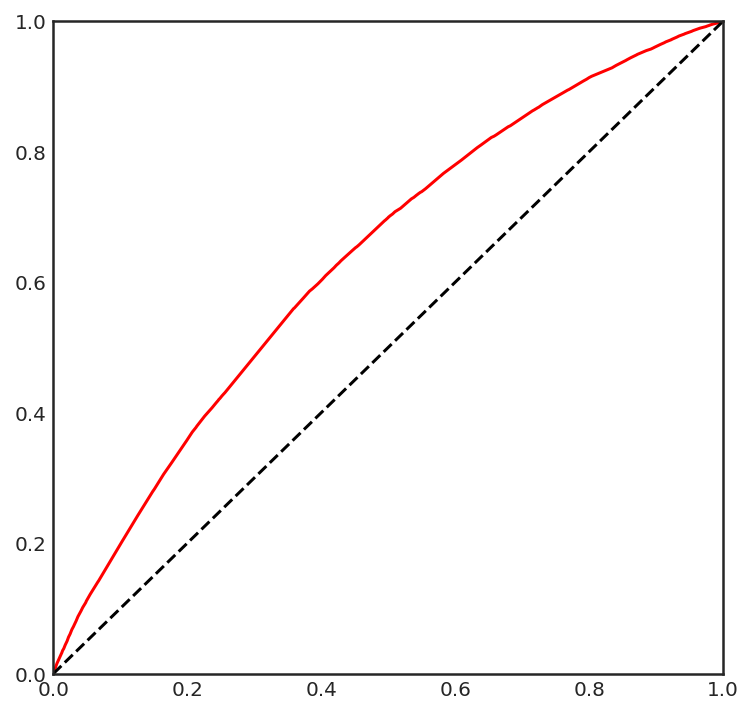

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, th = roc_curve(y_test, gb.predict_proba(x_test)[:,1])
print(roc_auc_score(y_test, gb.predict_proba(x_test)[:,1]))

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

Confusion matrix:
 [[886375  43135]
 [190602  22590]]
Precision:  0.34370483073411945
Recall:  0.10596082404593044
Accuracy:  0.7954523576575521
False Negative Rate:  0.1769787098517424
Accuracy:  0.7954523576575521
0.5297773265263057


(0, 1)

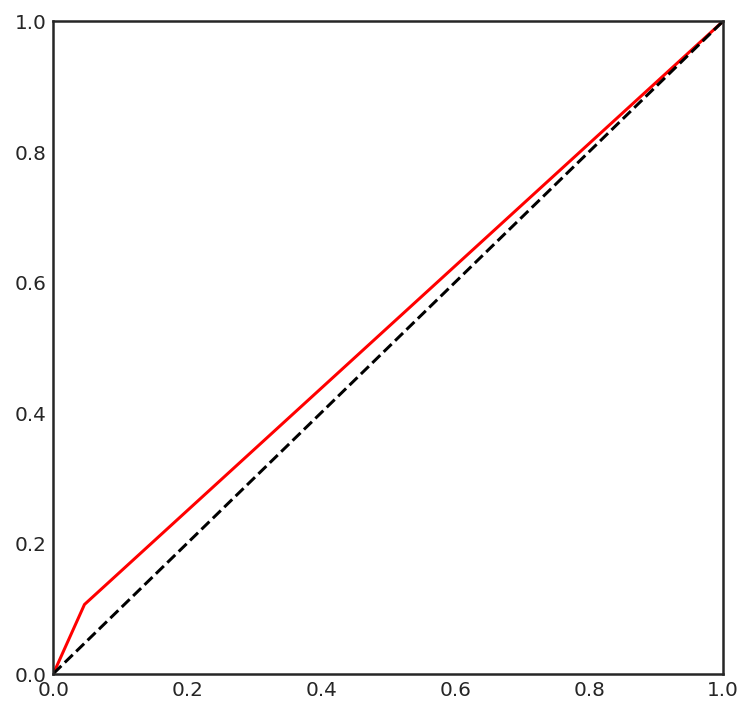

In [24]:
from sklearn.metrics import confusion_matrix
decision_thresh = .3
all_preds = gb.predict_proba(x_test)[:,1] > decision_thresh
all_ys = y_test
all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
print('False Negative Rate: ', all_confuse[1,0]/(all_confuse[1,0]+all_confuse[0,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

# Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
C = 100
model = LogisticRegression(C=C)
model.fit(x_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
preds_train = model.predict(x_train)
preds_val = model.predict(x_test)
print(model.score(x_train, y_train))
print(sum(model.predict(x_train)))
print(model.score(x_test, y_test))
print(sum(model.predict(x_test)))


0.8139809477803258
82
0.8134377991812388
25


0.6418345266306302


(0, 1)

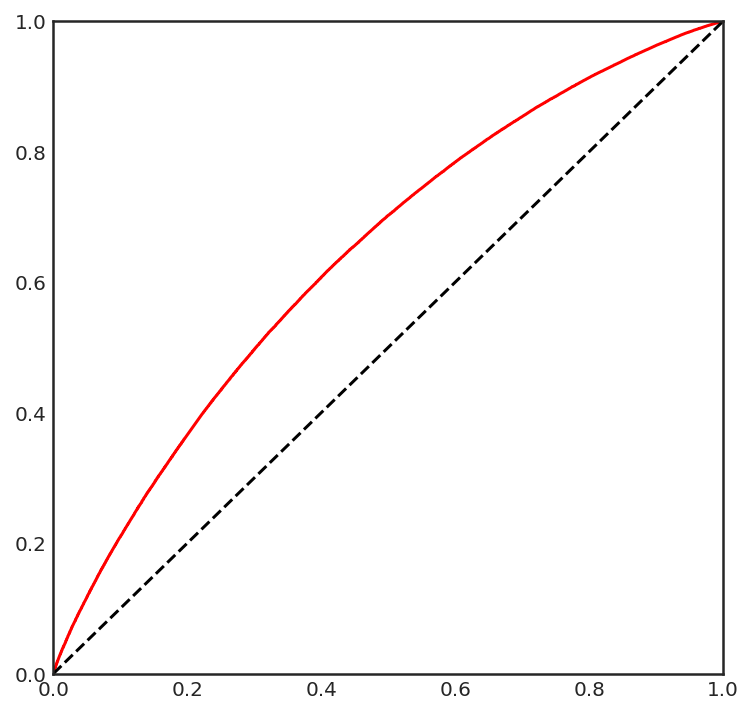

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, th = roc_curve(y_test, model.predict_proba(x_test)[:,1])
print(roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

Confusion matrix:
 [[868711  60799]
 [181701  31491]]
Precision:  0.3412179000975187
Recall:  0.14771192164809185
Accuracy:  0.7877836916361396
0.5411510948193767


(0, 1)

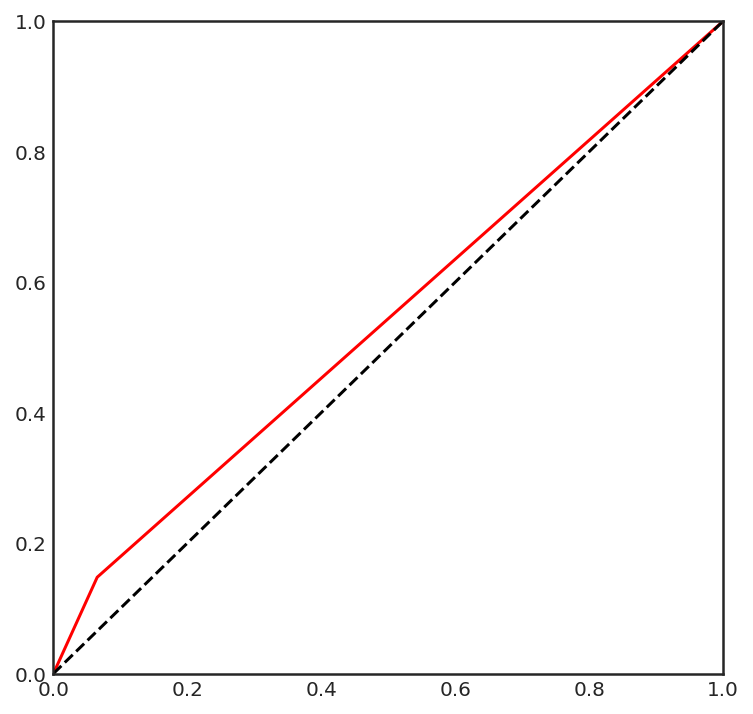

In [29]:
decision_thresh = .3
all_preds = model.predict_proba(x_test)[:,1] > decision_thresh
all_ys = y_test
all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))